# Import all dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


# Set all the constants

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

# Import data into tensorflow data object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\USER\Downloads\disease detection\tomato new",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6969 files belonging to 7 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato___Leaf_Mold',
 'Tomato___Leaf_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'tomato_verticulium wilt']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[6 1 2 0 6 1 4 3 5 4 0 1 0 3 1 5]


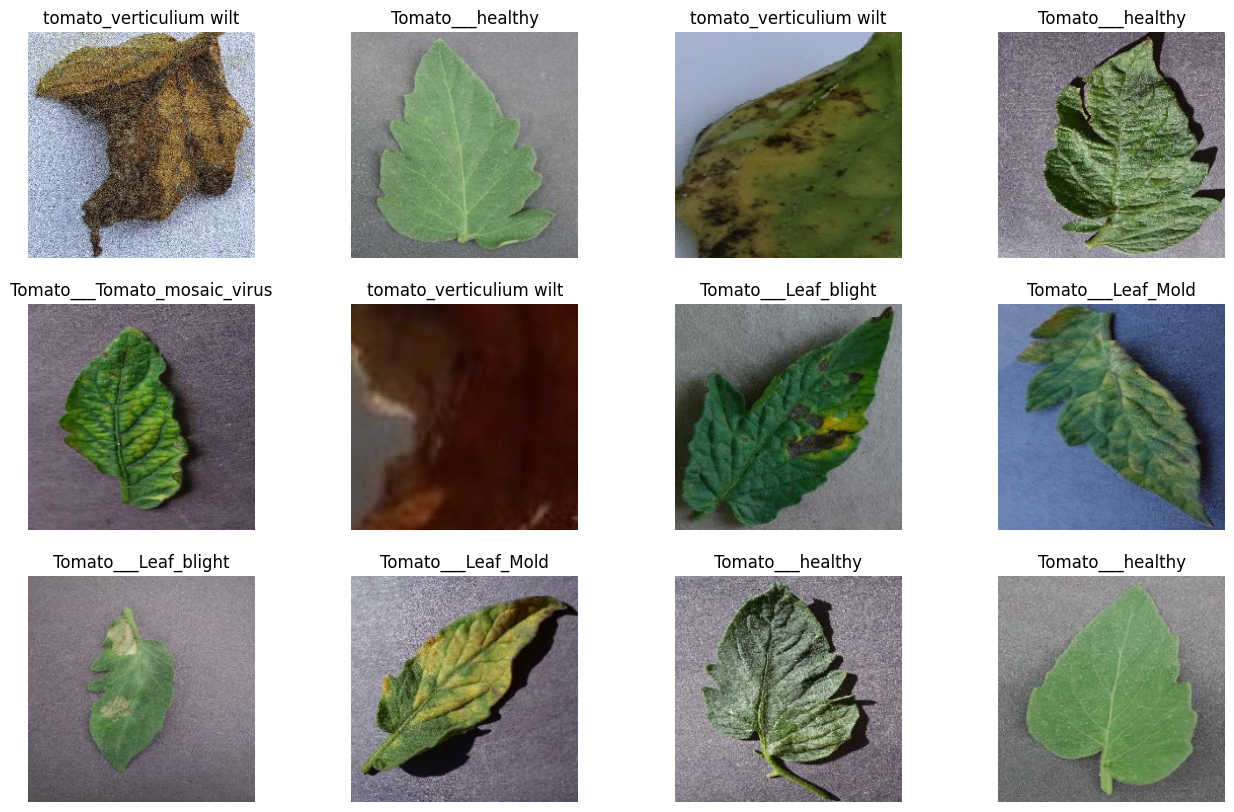

In [7]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    batch_size = min(12, BATCH_SIZE)
    for i in range(batch_size):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
len(dataset)

436

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

348

In [12]:
len(val_ds)

43

In [13]:
len(test_ds)

45

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 222, 222, 32)        896       
                                                                 
 batch_normalization (Batch  (16, 222, 222, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (16, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 109, 109, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (16, 109, 109, 64)       

In [20]:
from keras.optimizers import Adam

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    
  # Add class weights here
)


In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
348/348 [==============================] - 1087s 3s/step - loss: 0.9690 - accuracy: 0.6634 - val_loss: 4.2984 - val_accuracy: 0.1672
Epoch 2/10
348/348 [==============================] - 880s 3s/step - loss: 0.5944 - accuracy: 0.7909 - val_loss: 1.0436 - val_accuracy: 0.6701
Epoch 3/10
348/348 [==============================] - 706s 2s/step - loss: 0.4375 - accuracy: 0.8459 - val_loss: 0.9245 - val_accuracy: 0.6948
Epoch 4/10
348/348 [==============================] - 1046s 3s/step - loss: 0.3682 - accuracy: 0.8691 - val_loss: 1.6074 - val_accuracy: 0.6468
Epoch 5/10
348/348 [==============================] - 1191s 3s/step - loss: 0.3440 - accuracy: 0.8810 - val_loss: 0.3162 - val_accuracy: 0.8852
Epoch 6/10
348/348 [==============================] - 1029s 3s/step - loss: 0.2834 - accuracy: 0.8953 - val_loss: 0.3715 - val_accuracy: 0.8677
Epoch 7/10
348/348 [==============================] - 1067s 3s/step - loss: 0.2745 - accuracy: 0.9070 - val_loss: 2.2462 - val_accuracy: 0

In [22]:
# scores = model.evaluate(test_ds)

test_loss, test_accuracy = model.evaluate(test_ds)

45/45 [==============================] - 33s 342ms/step - loss: 0.9768 - accuracy: 0.7389


In [23]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.9767864942550659
Test Accuracy: 0.7388888597488403


In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have the model predictions and true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


45/45 [==============================] - 16s 330ms/step
Confusion Matrix:
[[11  7 33 10 18 25 20]
 [13  9 24  3 17 19 10]
 [11  6 24  6 14 17 12]
 [17  3 30  5 24 16 14]
 [ 7  9 30  4 17 14 19]
 [ 8 10 31  8 16 15 16]
 [15  3 33  7 14 15 11]]


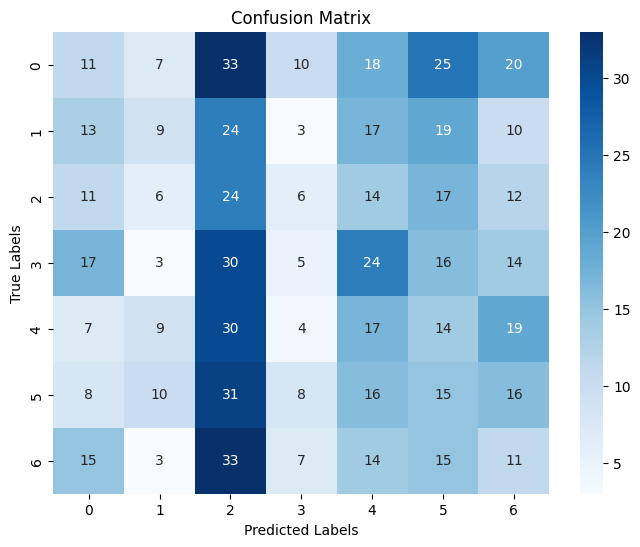

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = 7
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
class_report = classification_report(y_true, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.09      0.11       124
           1       0.19      0.09      0.13        95
           2       0.12      0.27      0.16        90
           3       0.12      0.05      0.07       109
           4       0.14      0.17      0.15       100
           5       0.12      0.14      0.13       104
           6       0.11      0.11      0.11        98

    accuracy                           0.13       720
   macro avg       0.13      0.13      0.12       720
weighted avg       0.13      0.13      0.12       720



In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 348}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])

list

In [31]:
len(history.history['loss'])

10

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9690303802490234,
 0.5944112539291382,
 0.4374760389328003,
 0.3682444095611572,
 0.3440409302711487]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

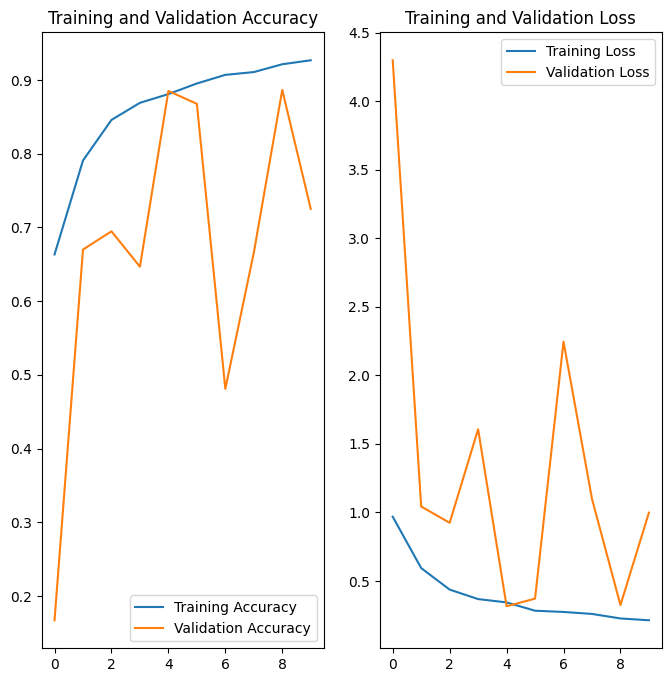

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato___Tomato_mosaic_virus
1/1 [==============================] - 1s 558ms/step
predicted label: Tomato___Tomato_mosaic_virus


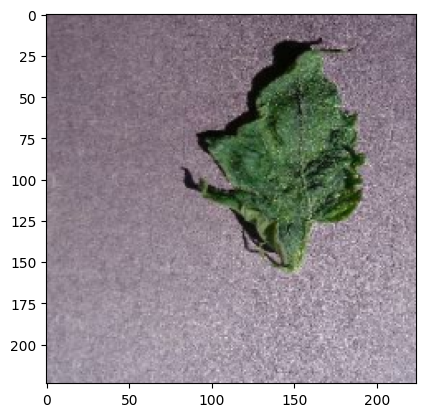

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


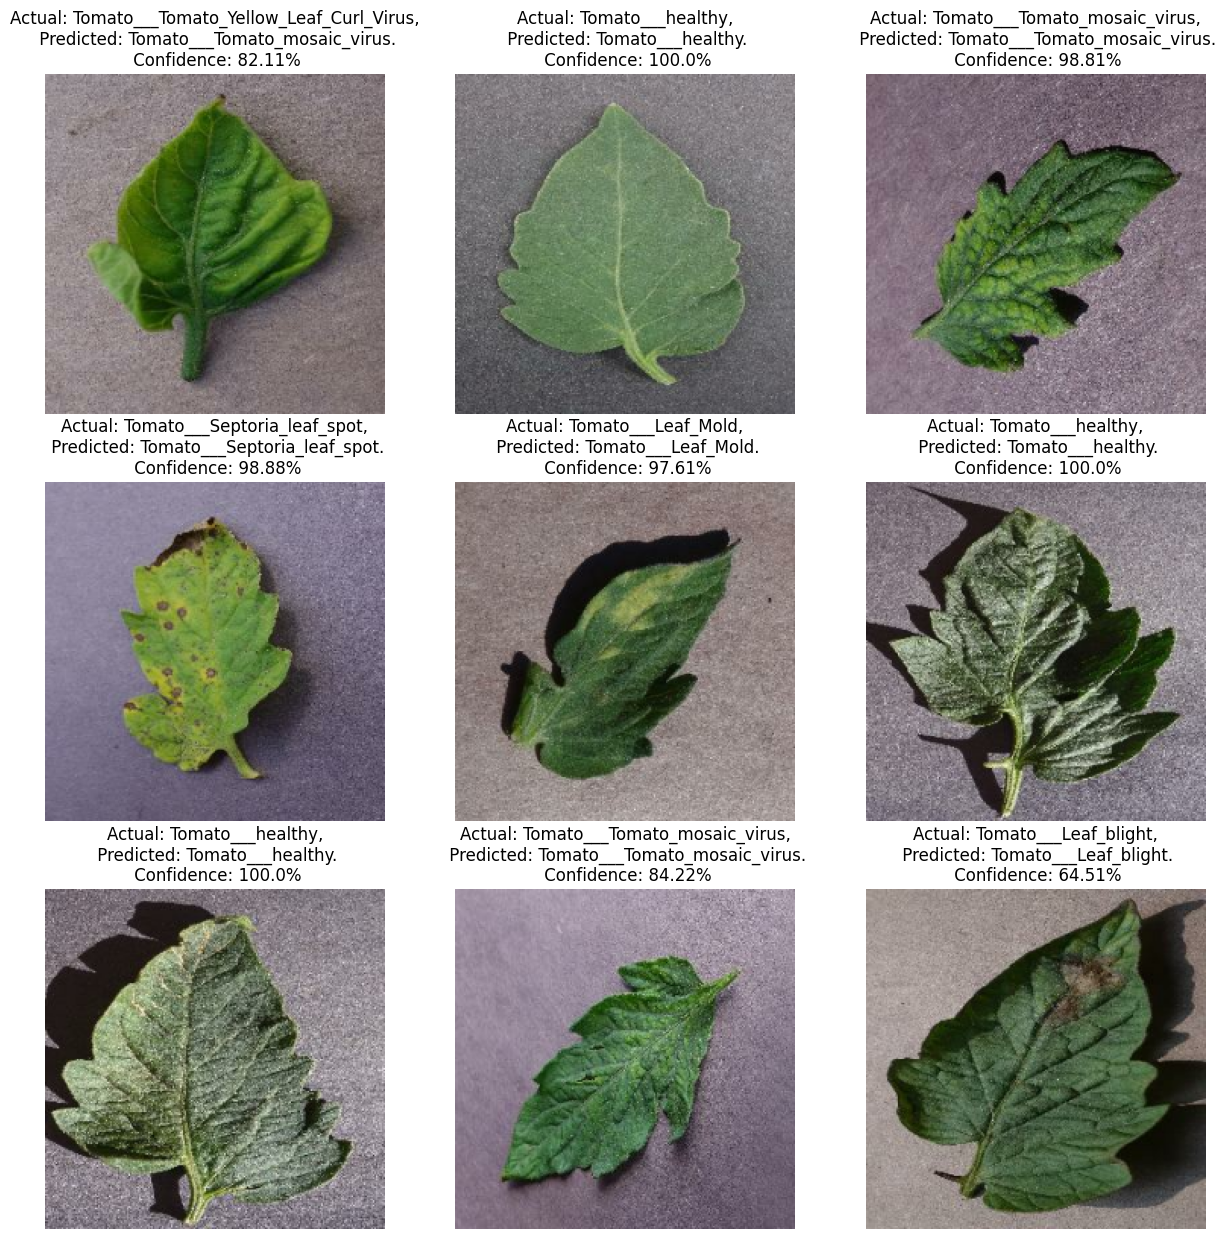

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
import os

# Get all directories in "../models"
directory_path = r"C:\Users\USER\Downloads\disease detection\new models"
directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Extract numeric parts from directory names
versions = [int(''.join(filter(str.isdigit, d))) for d in directories if any(char.isdigit() for char in d)]

# Find the maximum version number
model_version = max(versions + [0]) + 1

# Save the model
model.save(os.path.join(directory_path, str(model_version), "tomato.h5"))


C:\Users\USER\anacondaa\envs\myyenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
